##  Word2vec and CBOW ⚡


In this assignment, we will guide you through the process of implementing Continous Bag Of Words (CBOW) using PyTorch, providing step-by-step instructions, code snippets, and explanations to aid your understanding. By the end of this assignment, you will have a solid grasp of Word2Vec's mechanics and be equipped to apply this knowledge to a wide range of NLP tasks.

Let's embark on this journey to unlock the power of word embeddings with Word2Vec and PyTorch!

This [guide](https://pytorch.org/tutorials/beginner/basics/intro.html) might come in handy to understand how Pytorch works.

Let's start by installing the needed libraries

In [ ]:
!pip install datasets
!gdown https://drive.google.com/file/d/1-mB6idLW5Jg4aE68jOj5NDcDxRNlMXpu/view?usp=sharing --fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1-mB6idLW5Jg4aE68jOj5NDcDxRNlMXpu
To: /content/TestSet_sample.csv
100% 51.5k/51.5k [00:00<00:00, 59.2MB/s]


In this assigment we will use the data set wikitext. This dataset is composed of textual content extracted from Wikipedia articles which hopefully will lead to good embeddings when input in CBOW.

In [ ]:
from datasets import load_dataset
from random import sample

wikitext = load_dataset("wikipedia", "20220301.simple")
trim_dataset= sample(wikitext['train']['text'],5000)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

wikipedia.py:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

The repository for wikipedia contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/wikipedia.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


train-00000-of-00001.parquet:   0%|          | 0.00/134M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/205328 [00:00<?, ? examples/s]

In [ ]:
trim_dataset[0]

'Monsures is a commune. It is in Hauts-de-France in the Somme department in north France.\n\nReferences \n\nCommunes in Somme'

As you can see there are a lot of numeric values, end-of-lines and the word "References" at the end. We saw in the previous assigment how preprocessing can significantly reduce the vocabulary; feel free to base the following code in your previous work.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string
import re
from nltk.corpus import stopwords

def preprocess_data(data):
    """
    Method to clean text from noise and standardize text across the different classes.
    The preprocessing includes joining all data points, converting to lowercase,
    removing punctuation, removing stopwords, and other noise.

    Arguments
    ---------
    data : List of Strings
        List of texts to clean.

    Returns
    -------
    text : String
        Cleaned and joined text.
    """

    # Load stopwords
    stop_words = set(stopwords.words('english'))

    # Step 1: Join all data into a single string
    text = ' '.join(data)

    # Step 2: Convert text to lowercase
    text = text.lower()

    # Step 3: Remove newline characters
    text = text.replace('\n', ' ')

    # Step 4: Remove the word "References" (if this is a common issue in your dataset)
    text = re.sub(r'\breferences\b', '', text)

    # Step 5: Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 6: Remove all numbers
    text = re.sub(r'\d+', '', text)

    # Step 7: Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text
text=preprocess_data(trim_dataset)

Our `text` variable includes all the data in just one string. Let's create a dictionary of frequencies for more pre-processing (same as in the last assigment).

In [ ]:
def vocab_frequency(text):
    """
    Creates a dictionary of word frequencies based on a dataset.

    Arguments
    ---------
    text : String
        Preprocessed text in which words will be counted.

    Returns
    -------
    vocab_dict : dictionary
        Dictionary of words and their frequencies with the format {word: frequency}.
    """

    vocab_dict = {}

    # Split the text into words
    words = text.split()

    # Count the frequency of each word
    for word in words:
        if word in vocab_dict:
            vocab_dict[word] += 1
        else:
            vocab_dict[word] = 1

    return vocab_dict


vocabulary = vocab_frequency(text)

In [ ]:
len(vocabulary)

60847

Now our vocabulary is ready 😎

Since our neural networks can't understand strings we have to turn these strings into integers. In this case, we can use the vocabulary index to represent the words, so we will need the mapping: word -> index

In [ ]:
import torch
import torch.nn as nn

def word_to_index(vocabulary):
    """
    Method to create a mapping from words to index.

    Arguments
    ---------
    vocabulary : Dictionary
        Dictionary of format {word: frequency}

    Returns
    -------
    word_to_index : Dictionary
        Dictionary mapping words to indices with format {word: index}
    """

    word_to_index = {}

    # Special token for out-of-vocabulary (OOV) words
    word_to_index['<OOV>'] = 0  # Index 0 reserved for OOV words

    # Assign each word in the vocabulary a unique index starting from 1
    for i, word in enumerate(vocabulary.keys(), start=1):
        word_to_index[word] = i

    return word_to_index

word_to_index = word_to_index(vocabulary)


Let's start to get more on topic. If you remember, Word2Vec has a specific way of generating each vector.
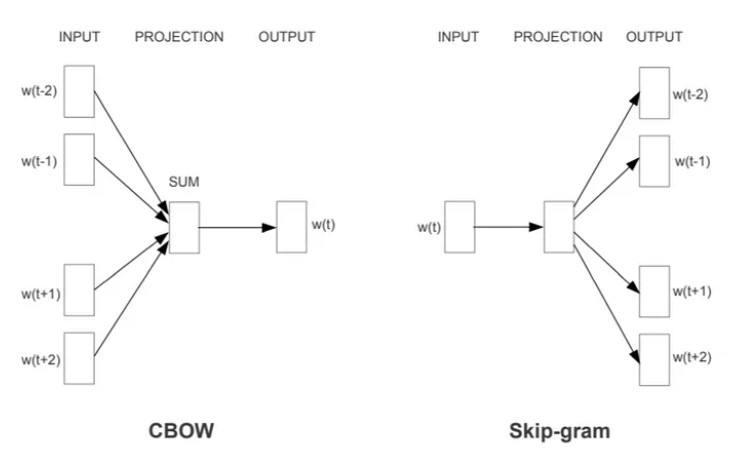

The embedding is based on the surrounding words (before and after) taken as context. In the case of CBOW, we input the surrounding words to our neural network and expect that it predicts the middle word. Let's format our dataset to meet the needs of the neural network.


In [ ]:
import torch

def generate_dataset(data, window_size, word_to_index):
    """
    Method to generate training dataset for CBOW.

    Arguments
    ---------
    data : String
        Training dataset (a single string).
    window_size : int
        Size of the context window (number of words before and after the target).
    word_to_index : Dictionary
        Dictionary mapping words to indices with format {word: index}.

    Returns
    -------
    surroundings : Tensor
        Tensor with indices of surrounding words, shape (N x 2*window_size), where N is the number of samples.
    targets : Tensor
        Tensor with indices of target words, shape (N,).
    """

    surroundings = []
    targets = []

    # Split the input data into a list of words
    data = data.split(" ")

    # Iterate through the dataset starting at window_size and stopping window_size before the end
    for i in range(window_size, len(data) - window_size):
        # Collect the surrounding words, window_size on both sides of the target word
        surrounding = data[i - window_size:i] + data[i + 1:i + 1 + window_size]

        # Convert the surrounding words to their indices
        surrounding_indices = [word_to_index.get(word, word_to_index['<OOV>']) for word in surrounding]

        # Get the target word (the word in the middle) and convert it to its index
        target_word = data[i]
        target_index = word_to_index.get(target_word, word_to_index['<OOV>'])

        # Append the surrounding indices and target index to their respective lists
        surroundings.append(surrounding_indices)
        targets.append(target_index)

    # Convert lists to tensors for PyTorch compatibility
    surroundings_tensor = torch.tensor(surroundings, dtype=torch.long)
    targets_tensor = torch.tensor(targets, dtype=torch.long)

    return surroundings_tensor, targets_tensor


surroundings, targets = generate_dataset(text, window_size=2, word_to_index=word_to_index)

With our dataset ready we can finally create our Neural Network. The idea is to replicate what Mikolov did in 2013 (see slides of Word2Vec).

In [ ]:
print(surroundings.shape, targets.shape)

torch.Size([492594, 4]) torch.Size([492594])


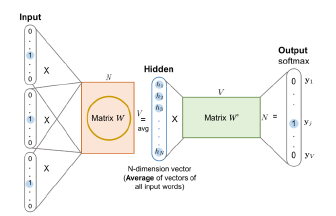

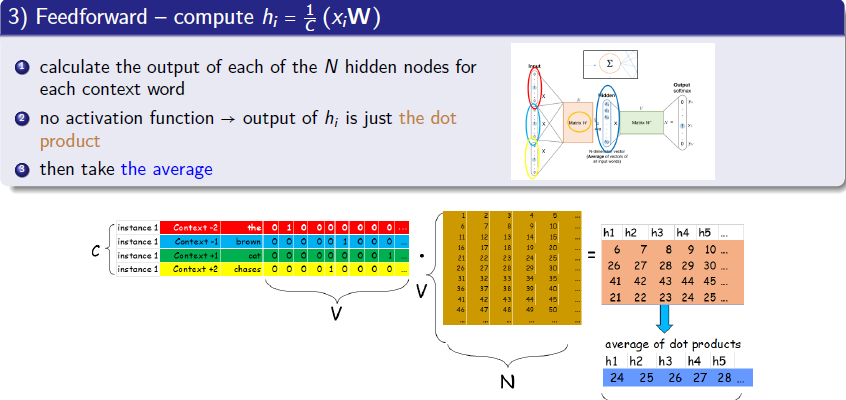

In [ ]:
import torch
import torch.nn as nn

class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim=300):
        """
        Class to define the CBOW model.

        Attributes
        ---------
        vocab_size : int
            Size of the vocabulary
        embed_dim : int
            Size of the embedding layer (dimension of word vectors)
        """
        super(CBOW, self).__init__()

        # Embedding layer to map word indices to dense vectors of size embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Linear layer to project the average embedding into the vocabulary size space
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        """
        Forward pass through the network.

        Arguments
        ---------
        x : Tensor
            Input tensor containing indices of the surrounding words, shape: (batch_size, context_window * 2)

        Returns
        -------
        out : Tensor
            Output tensor representing the predicted scores for each word in the vocabulary, shape: (batch_size, vocab_size)
        """

        # Pass input through the embedding layer (shape: (batch_size, context_window * 2, embed_dim))
        emb = self.embedding(x)

        # Compute the average of the embeddings over the context window (axis 1)
        # Resulting shape: (batch_size, embed_dim)
        average = torch.mean(emb, dim=1)

        # Normalize the averaged embedding (L2 normalization)
        normalized_average = average / average.norm(dim=1, keepdim=True)

        # Pass the normalized averaged embedding through the linear layer (shape: (batch_size, vocab_size))
        out = self.linear(normalized_average)

        return out


print(surroundings.shape, targets.shape)

In [ ]:
from torch.utils.data import DataLoader

# Create DataLoader for training data
batch_size = 64  # Adjust this based on your GPU's capacity
train_dataloader = DataLoader(
    list(zip(surroundings, targets)), batch_size=batch_size, shuffle=True
)


In [ ]:
from tqdm import tqdm
import torch

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = CBOW(len(word_to_index)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

# Train the model
for epoch in range(epochs):
    total_loss = 0
    i = 0
    model.train()  # Set the model to training mode

    for surr, tar in tqdm(train_dataloader):
        # Move data to the appropriate device (GPU or CPU)
        surr, tar = surr.to(device), tar.to(device)

        # Clear gradients for the optimizer
        optimizer.zero_grad()

        # Forward pass: Get predictions from the model
        log_probs = model(surr)

        # Compute the loss between predicted output and actual target
        loss = loss_function(log_probs, tar)

        # Add the loss to the running total loss
        total_loss += loss.item()

        # Backward pass: compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

    # Print the average loss for the epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataloader)}")


100%|██████████| 7697/7697 [01:54<00:00, 67.46it/s]


Epoch 1/10, Loss: 9.31131941488196


100%|██████████| 7697/7697 [01:51<00:00, 68.93it/s]


Epoch 2/10, Loss: 8.216178706703023


100%|██████████| 7697/7697 [01:51<00:00, 68.96it/s]


Epoch 3/10, Loss: 7.651694781256447


100%|██████████| 7697/7697 [01:51<00:00, 68.94it/s]


Epoch 4/10, Loss: 7.182895281198072


100%|██████████| 7697/7697 [01:51<00:00, 68.96it/s]


Epoch 5/10, Loss: 6.759742878436485


100%|██████████| 7697/7697 [01:51<00:00, 68.96it/s]


Epoch 6/10, Loss: 6.364987672389723


100%|██████████| 7697/7697 [01:51<00:00, 68.96it/s]


Epoch 7/10, Loss: 5.989703947094271


100%|██████████| 7697/7697 [01:51<00:00, 68.86it/s]


Epoch 8/10, Loss: 5.62789958759579


100%|██████████| 7697/7697 [01:51<00:00, 68.99it/s]


Epoch 9/10, Loss: 5.278389606597254


100%|██████████| 7697/7697 [01:51<00:00, 68.90it/s]

Epoch 10/10, Loss: 4.9399397224516965


## Let's test it! 🤓

Now that we hopefully have good embeddings we can put them to the test. Let's start by creating some useful functions.

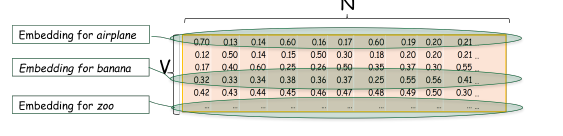

In [ ]:
import torch

def get_embedding(word, model, word_to_index):
    """
    Method to get the embedding vector for a given word.

    Arguments
    ---------
    word : String
        Word given.
    model : nn.Module
        CBOW model containing the embedding layer.
    word_to_index : Dictionary
        Dictionary mapping words to index with format {word: index}.

    Returns
    -------
    word_embedding : Tensor
        Embedding vector for the given word.
    """
    # Get the index for the given word, or handle OOV words
    index = word_to_index.get(word, word_to_index.get('<OOV>'))  # Use <OOV> if word not in vocabulary

    # Ensure no gradients are calculated (inference mode)
    with torch.no_grad():
        # Get the weights from the embedding layer in the model
        embedding_weights = model.embedding.weight  # Assuming your model has an 'embedding' attribute
        embedding_weights.requires_grad = False

        # Extract the embedding vector for the given word index
        word_embedding = embedding_weights[index]

    return word_embedding

# Test the function by getting the embedding of the word "shot"
word_embedding = get_embedding("shot", model, word_to_index)
print(f"Embedding for 'shot': {word_embedding}")






Embedding for 'shot': tensor([ 0.4906,  0.4058, -0.2096, -0.0825, -0.4296,  0.9605,  0.6184, -0.6737,
        -0.2662, -0.3394, -0.7091, -0.7375,  2.9506,  0.6168,  0.0698,  1.2080,
        -1.5716, -0.7252, -2.5542,  0.2557,  2.3047, -1.1911,  0.2084,  0.2010,
        -1.2168, -1.3964,  1.0020,  0.2814, -0.7739, -1.2707,  0.2911, -1.2924,
         0.2945, -0.2626, -0.1390, -1.5841, -1.8393, -1.2004, -1.7925,  0.5352,
        -1.0450, -1.3900, -0.1019,  0.0335, -1.2053,  1.2193, -0.1586, -0.2722,
        -1.2070,  0.2006,  1.7352, -0.3360, -0.1414,  0.7695, -0.8912, -2.0434,
         0.0706, -0.9972, -0.2261,  0.1900,  1.0348, -0.1160,  0.4793, -1.0945,
         1.8457, -0.0371, -0.0822, -0.2489,  0.6893, -0.1574, -0.4453, -1.2365,
        -0.5821,  0.5904,  0.4173, -1.7085, -0.3306, -0.8262, -0.0429, -0.3440,
         0.8920, -1.2269,  1.3997,  0.2008,  0.1899, -0.8591,  0.9244,  1.8702,
        -0.8124, -1.6061, -1.5608,  0.6280,  0.1056, -0.0785, -1.6354,  1.0180,
         0.5638,  

In [ ]:
print(f"Embedding size: {word_embedding.shape}")


Embedding size: torch.Size([300])


In [ ]:
# Check the size of your vocabulary
print(f"Vocabulary size: {len(word_to_index)}")

# Print the first 50 words in the vocabulary to get a sense of what it contains
print(list(word_to_index.keys())[:50])


Vocabulary size: 60848
['<OOV>', 'monsures', 'commune', 'hautsdefrance', 'somme', 'department', 'north', 'france', 'communes', 'john', 'stewart', 'herrington', 'born', 'may', 'american', 'republican', 'politician', 'served', 'united', 'states', 'secretary', 'energy', 'ronald', 'reagan', 'second', 'term', 'websites', 'clean', 'corp', 'bio', 'forbes', 'profile', 'births', 'living', 'people', 'secretaries', 'us', 'party', 'politicians', 'california', 'los', 'angeles', 'johnny', 'destiny', 'space', 'ranger', 'black', 'knight', 'korean', 'captain']


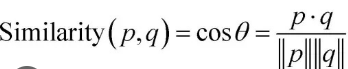

In [ ]:
import torch

def cosine_similarity(v1, v2):
    """
    Method to calculate cosine similarity between two vectors.

    Arguments
    ---------
    v1 : Tensor
        First vector.
    v2 : Tensor
        Second vector.

    Returns
    -------
    cosine_sim : float
        Cosine similarity between v1 and v2.
    """
    dot_product = torch.dot(v1, v2)  # Calculate the dot product
    v1_norm = torch.norm(v1)  # Calculate the norm of v1
    v2_norm = torch.norm(v2)  # Calculate the norm of v2

    # Avoid division by zero
    if v1_norm == 0 or v2_norm == 0:
        return 0.0

    cosine_sim = dot_product / (v1_norm * v2_norm)  # Compute cosine similarity
    return cosine_sim.item()  # Convert to Python float



In [ ]:
word_embedding = get_embedding("shot", model, word_to_index)
print(f"Embedding for 'shot': {word_embedding}")

Embedding for 'shot': tensor([ 0.4906,  0.4058, -0.2096, -0.0825, -0.4296,  0.9605,  0.6184, -0.6737,
        -0.2662, -0.3394, -0.7091, -0.7375,  2.9506,  0.6168,  0.0698,  1.2080,
        -1.5716, -0.7252, -2.5542,  0.2557,  2.3047, -1.1911,  0.2084,  0.2010,
        -1.2168, -1.3964,  1.0020,  0.2814, -0.7739, -1.2707,  0.2911, -1.2924,
         0.2945, -0.2626, -0.1390, -1.5841, -1.8393, -1.2004, -1.7925,  0.5352,
        -1.0450, -1.3900, -0.1019,  0.0335, -1.2053,  1.2193, -0.1586, -0.2722,
        -1.2070,  0.2006,  1.7352, -0.3360, -0.1414,  0.7695, -0.8912, -2.0434,
         0.0706, -0.9972, -0.2261,  0.1900,  1.0348, -0.1160,  0.4793, -1.0945,
         1.8457, -0.0371, -0.0822, -0.2489,  0.6893, -0.1574, -0.4453, -1.2365,
        -0.5821,  0.5904,  0.4173, -1.7085, -0.3306, -0.8262, -0.0429, -0.3440,
         0.8920, -1.2269,  1.3997,  0.2008,  0.1899, -0.8591,  0.9244,  1.8702,
        -0.8124, -1.6061, -1.5608,  0.6280,  0.1056, -0.0785, -1.6354,  1.0180,
         0.5638,  

Second Version

In [ ]:
import torch

def get_k_nearest_words(k, input_vector, vocabulary, model, word_to_index, exclude_words=None, is_word=True):
    """
    Method to find the k nearest words of a given word or vector.

    Arguments
    ---------
    k : int
        Number of nearest words to return.
    input_vector : Tensor or String
        If is_word is True, this should be the word. Otherwise, a vector.
    vocabulary : Dictionary
        Dictionary mapping words to their frequency (or presence).
    model : nn.Module
        Trained CBOW model.
    word_to_index : Dictionary
        Dictionary mapping words to indices.
    exclude_words : List of Strings, optional
        Words to exclude from the results (e.g., input words in analogy).
    is_word : bool, optional
        If True, input is treated as a word; otherwise, as a vector.

    Returns
    -------
    similar : List of Strings
        List of k nearest words.
    """
    # # Get the embedding if the input is a word
    # if is_word:
    #     input_vector = get_embedding(input_vector, model, word_to_index)

    similarity_scores = torch.zeros(len(vocabulary))
    vocab_keys = list(vocabulary.keys())

    # Compute cosine similarities for all words in the vocabulary
    for i, other_word in enumerate(vocab_keys):
        if exclude_words and other_word in exclude_words:
            similarity_scores[i] = -float('inf')  # Exclude specified words
            continue

        other_word_embedding = get_embedding(other_word, model, word_to_index)
        similarity_scores[i] = cosine_similarity(input_vector, other_word_embedding)

    # Get the top k most similar words
    k_first = torch.topk(similarity_scores, k)
    similar = [vocab_keys[idx] for idx in k_first.indices]

    return similar


In [ ]:
# Get the embedding vector for the word "shot"
shot_embedding = get_embedding("shot", model, word_to_index)

# Use the existing get_k_nearest_words function
similar_words = get_k_nearest_words(
    k=5,
    input_vector=shot_embedding,  # Pass the embedding vector of "shot"
    vocabulary=vocabulary,
    model=model,
    word_to_index=word_to_index,
    is_word=False  # Since we are passing an embedding vector, not a word
)

# Print the top 5 similar words to 'shot'
print(f"Top 5 words similar to 'shot': {similar_words}")



Top 5 words similar to 'shot': ['shot', 'baritoneeuphonium', 'sidecar', 'nagraj', 'raj']


In [ ]:
for similar_word in similar_words:
    # Get the embedding for each similar word
    similar_word_embedding = get_embedding(similar_word, model, word_to_index)

    # Calculate the cosine similarity between "shot" and the similar word
    similarity = cosine_similarity(shot_embedding, similar_word_embedding)

    # Print the word and its similarity score
    print(f"{similar_word}: {similarity:.4f}")

shot: 1.0000
baritoneeuphonium: 0.2483
sidecar: 0.2297
nagraj: 0.2136
raj: 0.2126


The Google analogy test set is a state of the art data set for word embeddings that tests their ability to solve analogy tasks. A well-known example for it is: "king is to man as queen is to women." We will use a subset of this dataset to see how our CBOW model performs.


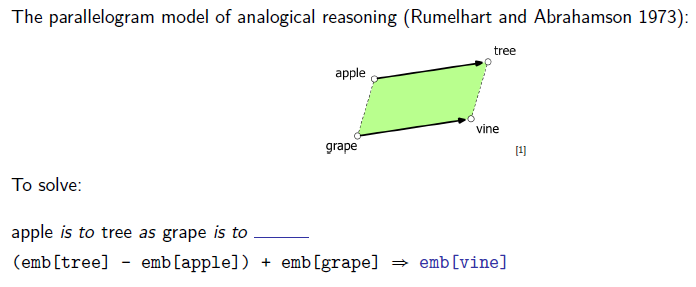

In [ ]:
import pandas as pd

def test_analogy(model, word_to_index, analogy_file, subset_size=None):
    """
    Method to test accuracy of CBOW embeddings on analogy tasks.

    Arguments
    ---------
    model : nn.Module
        Trained CBOW model.
    word_to_index : Dictionary
        Dictionary mapping words to indices {word: index}.
    analogy_file : String
        File containing analogy tasks.
    subset_size : int, optional
        Number of rows to use from the dataset (for testing purposes).

    Returns
    -------
    accuracy : float
        Accuracy of the model on the analogy tasks.
    """
    # Load the CSV file
    df = pd.read_csv(analogy_file)

    # Filter by the 'capital-common-countries' category
    df = df[df['category'] == 'capital-common-countries']

    # Reduce the dataset size for testing, if subset_size is provided
    if subset_size:
        df = df.head(subset_size)

    correct = 0
    total = 0
    skipped = 0  # Counter for skipped tasks

    # Iterate through each analogy task
    for index, row in df.iterrows():
        word_one = row['word_one'].lower()
        word_two = row['word_two'].lower()
        word_three = row['word_three'].lower()
        word_four = row['word_four'].lower()

        # Skip tasks if any word is not in the vocabulary
        if (word_one not in word_to_index) or (word_two not in word_to_index) or \
           (word_three not in word_to_index) or (word_four not in word_to_index):
            skipped += 1
            continue

        # Get embeddings for the words
        embedding_word_one = get_embedding(word_one, model, word_to_index)
        embedding_word_two = get_embedding(word_two, model, word_to_index)
        embedding_word_three = get_embedding(word_three, model, word_to_index)

        # Compute the resulting analogy vector
        result_embedding = embedding_word_two - embedding_word_one + embedding_word_three

        # Find the top 3 nearest words to the result
        predictions = get_k_nearest_words(10, result_embedding, word_to_index, model, word_to_index)

        # Print detailed results
        is_correct = word_four in predictions
        print(f"Analogy: {word_one} -> {word_two} :: {word_three} -> {word_four} | Prediction: {predictions}, Correct: {is_correct}")

        if is_correct:
            correct += 1

        total += 1

    # Print final stats
    print(f"Total tasks skipped due to missing words: {skipped}")
    if total == 0:
        print("No valid tasks were processed.")
        return 'No word was found in the embeddings'

    accuracy = correct / total
    print(f"Analogy task accuracy: {accuracy:.4f}")
    return accuracy

# Test the model on a reduced subset for quick debugging (e.g., 10 rows)
accuracy = test_analogy(model, word_to_index, 'TestSet_sample.csv', subset_size=200)

# accuracy = test_analogy(model, word_to_index, 'TestSet_sample.csv')

Analogy: athens -> greece :: baghdad -> iraq | Prediction: ['baghdad', 'greece', 'ad', 'counterbalanced', 'féin', 'consumables', 'katzelsdorf', 'wass', 'fostering', 'marshman'], Correct: False
Analogy: athens -> greece :: bangkok -> thailand | Prediction: ['bangkok', 'greece', 'league', 'vedic', 'nasda', 'barros', 'avrakotos', 'mawddach', 'tecate', 'theater'], Correct: False
Analogy: athens -> greece :: beijing -> china | Prediction: ['greece', 'beijing', 'licensed', 'príncipe', 'convers', 'chair', 'soldiers', 'crespo', 'colonnades', 'league'], Correct: False
Analogy: athens -> greece :: berlin -> germany | Prediction: ['berlin', 'greece', 'orbital', 'hadrians', 'neumünster', 'detachment', 'league', 'centres', 'taliesin', 'productspecific'], Correct: False
Analogy: athens -> greece :: bern -> switzerland | Prediction: ['greece', 'bern', 'toukley', 'ticino', 'verda', 'nasda', 'juvenile', 'thorazine', 'yasmin', 'tibor'], Correct: False
Analogy: athens -> greece :: cairo -> egypt | Predic

Our model can do much better! In the "Let's experiment" part we will try to improve this model. Also depending on your GPU accesibility you can train for more epochs and data (making trim_dataset bigger in cell #3).

TSNE can be a very helpful and cool visualization method of our vectors, this way we can clearly see the relationship between different words (maybe even find some clusters!). Let's implement this visualization.

In [ ]:
import pandas as pd
import torch
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# Step 1: Load the analogy dataset
analogy_df = pd.read_csv('TestSet_sample.csv')

# Step 2: Extract words by category
family_words = set(analogy_df[analogy_df['category'] == 'family'][['word_one', 'word_two', 'word_three', 'word_four']].values.flatten())
capital_words = set(analogy_df[analogy_df['category'] == 'capital-common-countries'][['word_one', 'word_two', 'word_three', 'word_four']].values.flatten())

# Normalize words to lowercase to avoid mismatches
family_words = [word.lower() for word in family_words if word.lower() in word_to_index]
capital_words = [word.lower() for word in capital_words if word.lower() in word_to_index]

# Debugging: Print unmatched words
unmatched_family = [word for word in family_words if word not in word_to_index]
unmatched_capital = [word for word in capital_words if word not in word_to_index]

print(f"Unmatched family words: {unmatched_family}")
print(f"Unmatched capital words: {unmatched_capital}")

# Check if any category is empty
if not family_words or not capital_words:
    raise ValueError("One of the categories has no valid words in the vocabulary.")

# Step 4: Extract embeddings for each category
def get_embeddings_for_words(words):
    with torch.no_grad():
        return np.array([model.embedding.weight[word_to_index[word]].cpu().detach().numpy() for word in words])

family_embeddings = get_embeddings_for_words(family_words)
capital_embeddings = get_embeddings_for_words(capital_words)

# Combine all embeddings and labels
all_embeddings = np.vstack([family_embeddings, capital_embeddings])
all_labels = family_words + capital_words

# Step 5: Apply t-SNE on the combined embeddings
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
reduced_embeddings = tsne.fit_transform(all_embeddings)

# Step 6: Create a scatter plot using Plotly with color-coding by category
colors = ['blue'] * len(family_words) + ['green'] * len(capital_words)  # Assign colors based on category

fig = go.Figure()

# Add scatter plot with color-coding
fig.add_trace(go.Scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    mode='markers+text',
    text=all_labels,
    textposition='top center',
    marker=dict(size=10, color=colors, showscale=False),
    hoverinfo='text'
))

# Set plot title and axis labels
fig.update_layout(
    title="t-SNE Visualization of Family and Capital Words",
    xaxis=dict(title='t-SNE Dimension 1'),
    yaxis=dict(title='t-SNE Dimension 2'),
    height=800
)

# Display the plot
fig.show()



Unmatched family words: []
Unmatched capital words: []


In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# Step 1: Initialize t-SNE
# We will use 2 dimensions for visualization
tsne = TSNE(n_components=2, random_state=0, perplexity=30)

# Step 2: Get the embedding weights from the trained CBOW model
# We will take only the first 1000 words for visualization
with torch.no_grad():
    embeddings = model.embedding.weight[:1000].cpu().detach().numpy()  # Get the first 1000 words

# Step 3: Apply t-SNE to reduce dimensionality of the embeddings
reduced_embeddings = tsne.fit_transform(embeddings)

# Step 4: Get the first 1000 words from the vocabulary
# Create a reverse dictionary to map indices back to words
index_to_word = {index: word for word, index in word_to_index.items()}
words = [index_to_word[i] for i in range(1000)]

# Step 5: Create a scatter plot using Plotly
fig = go.Figure()

# Add a scatter plot trace
fig.add_trace(go.Scatter(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    mode='markers+text',
    text=words,
    textposition='top center',
    marker=dict(size=10, color=np.arange(1000), colorscale='Viridis', showscale=False),
    hoverinfo='text'
))

# Set plot title and labels
fig.update_layout(
    title="t-SNE Visualization of Word Embeddings",
    xaxis=dict(title='t-SNE Dimension 1'),
    yaxis=dict(title='t-SNE Dimension 2'),
    height=800
)

# Display the plot
fig.show()

## Let's Experiment!

Now it's your time to experiment.
- Find a new training corpus to train our CBOW model from scratch (it can be books, tweets, etc).  This should change the embeddings. Analyse and report how this new training set changes the vectors themselves and the accuracy on the analogy test.
- Test your embeddings on a different sub-section of the analogy dataset or another dataset. Analyse and report how these results compare with the original dataset.

Category: Family

In [ ]:
import pandas as pd

def test_analogy_2(model, word_to_index, analogy_file, subset_size=None):
    """
    Method to test accuracy of CBOW embeddings on analogy tasks.

    Arguments
    ---------
    model : nn.Module
        Trained CBOW model.
    word_to_index : Dictionary
        Dictionary mapping words to indices {word: index}.
    analogy_file : String
        File containing analogy tasks.
    subset_size : int, optional
        Number of rows to use from the dataset (for testing purposes).

    Returns
    -------
    accuracy : float
        Accuracy of the model on the analogy tasks.
    """
    # Load the CSV file
    df = pd.read_csv(analogy_file)

    # Filter by the 'capital-common-countries' category
    df = df[df['category'] == 'family']

    # Reduce the dataset size for testing, if subset_size is provided
    if subset_size:
        df = df.head(subset_size)

    correct = 0
    total = 0
    skipped = 0  # Counter for skipped tasks

    # Iterate through each analogy task
    for index, row in df.iterrows():
        word_one = row['word_one'].lower()
        word_two = row['word_two'].lower()
        word_three = row['word_three'].lower()
        word_four = row['word_four'].lower()

        # Skip tasks if any word is not in the vocabulary
        if (word_one not in word_to_index) or (word_two not in word_to_index) or \
           (word_three not in word_to_index) or (word_four not in word_to_index):
            skipped += 1
            continue

        # Get embeddings for the words
        embedding_word_one = get_embedding(word_one, model, word_to_index)
        embedding_word_two = get_embedding(word_two, model, word_to_index)
        embedding_word_three = get_embedding(word_three, model, word_to_index)

        # Compute the resulting analogy vector
        result_embedding = embedding_word_two - embedding_word_one + embedding_word_three

        # Find the top 3 nearest words to the result
        predictions = get_k_nearest_words(10, result_embedding, word_to_index, model, word_to_index)

        # Print detailed results
        is_correct = word_four in predictions
        print(f"Analogy: {word_one} -> {word_two} :: {word_three} -> {word_four} | Prediction: {predictions}, Correct: {is_correct}")

        if is_correct:
            correct += 1

        total += 1

    # Print final stats
    print(f"Total tasks skipped due to missing words: {skipped}")
    if total == 0:
        print("No valid tasks were processed.")
        return 'No word was found in the embeddings'

    accuracy = correct / total
    print(f"Analogy task accuracy: {accuracy:.4f}")
    return accuracy

# Test the model on a reduced subset for quick debugging (e.g., 10 rows)
accuracy = test_analogy_2(model, word_to_index, 'TestSet_sample.csv', subset_size=200)

# accuracy = test_analogy(model, word_to_index, 'TestSet_sample.csv')

Analogy: boy -> girl :: brother -> sister | Prediction: ['girl', 'brother', 'tornillo', 'eberhard', 'batsman', 'stood', 'haiduts', 'blaue', 'selfreferential', 'facade'], Correct: False
Analogy: boy -> girl :: brothers -> sisters | Prediction: ['brothers', 'girl', 'atc', 'db', 'missiles', 'discusses', 'affiliation', 'rowspanrosso', 'cpm', 'petr'], Correct: False
Analogy: boy -> girl :: dad -> mom | Prediction: ['girl', 'dad', 'willingham', 'saintexupéry', 'bulb', 'socialize', 'sinotibetan', 'gifuj', 'neuharth', 'inexplicable'], Correct: False
Analogy: boy -> girl :: father -> mother | Prediction: ['girl', 'father', 'ecological', 'midtwentieth', 'tornillo', 'german–french–english', 'hedberg', 'willingham', 'db', 'dads'], Correct: False
Analogy: boy -> girl :: grandfather -> grandmother | Prediction: ['grandfather', 'girl', 'starlifter', 'dangers', 'comingofage', 'limerick', 'willingham', 'bmw', 'pythagoras', 'jails'], Correct: False
Analogy: boy -> girl :: grandpa -> grandma | Prediction